In [1]:
import pandas as pd
import statsmodels.api as sm
import sqlalchemy
import psycopg2
import boto3
import json

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df=pd.read_csv('/Users/huanglis/Desktop/SC deep dive/raw_data.csv')

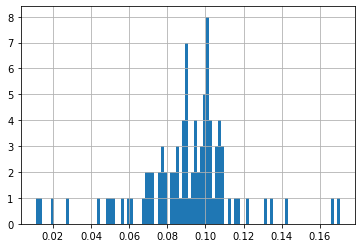

In [25]:
df['delta_tail_asin_perc'].hist(bins = 100)

In [3]:
df_copy = df.copy()

In [4]:
df_copy = pd.DataFrame(df_copy)
df_copy.columns

Index(['Unnamed: 0', 'ship_day', 'delta_upo', 'dealta_upb',
       'delta_estimated_zones', 'delta_air_per', 'delta_blank_box_perc',
       'delta_standard_ship_option_perc', 'delta_head_asin_perc',
       'delta_body_asin_perc', 'delta_tail_asin_perc',
       'delta_usps_sort_center_perc', 'delta_usps_perc', 'delta_swa_perc',
       'delta_others_perc', 'delta_small_standard_perc', 'delta_oversize_perc',
       'delta_large_standard_16oz_less_perc',
       'delta_large_standard_16oz_more_perc', 'delta_sc_per_unit'],
      dtype='object')

In [5]:
# Run sigmoid transform for dataset
import numpy as np
df_copy = df_copy.iloc[:,2:]
df_copy = df_copy.transform(lambda x: 1/(1+np.exp(-x)))

In [6]:
df_copy.head()

,delta_upo,dealta_upb,delta_estimated_zones,delta_air_per,delta_blank_box_perc,delta_standard_ship_option_perc,delta_head_asin_perc,delta_body_asin_perc,delta_tail_asin_perc,delta_usps_sort_center_perc,delta_usps_perc,delta_swa_perc,delta_others_perc,delta_small_standard_perc,delta_oversize_perc,delta_large_standard_16oz_less_perc,delta_large_standard_16oz_more_perc,delta_sc_per_unit
0,0.995599,0.927210,0.619523,0.495150,0.555100,0.666456,0.483431,0.492975,0.523607,0.578447,0.503425,0.401505,0.500375,0.482208,0.506050,0.476941,0.534769,0.499214
1,0.979407,0.674981,0.625903,0.486528,0.563358,0.673993,0.482133,0.493200,0.524630,0.605133,0.499900,0.388862,0.500400,0.484105,0.508924,0.475545,0.531433,0.582984
2,0.999973,0.855140,0.640557,0.501025,0.567952,0.664831,0.487478,0.491351,0.521187,0.592763,0.502625,0.379211,0.500500,0.486878,0.507999,0.479287,0.525827,0.638509
3,0.983013,0.718898,0.560061,0.480485,0.520813,0.653147,0.482557,0.495000,0.522435,0.614508,0.498550,0.380176,0.500425,0.483906,0.508924,0.475445,0.531682,0.538980
4,0.984161,0.821259,0.647171,0.482058,0.574589,0.672673,0.486328,0.491501,0.522160,0.591386,0.499825,0.392289,0.500300,0.490576,0.507075,0.478314,0.524031,0.583994


In [7]:
# Run min-max normalization
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
scale_vars = df_copy.columns
##scale_vars = ['delta_upo', 'dealta_upb', 'delta_estimated_zones', 'delta_head_asin_perc','delta_body_asin_perc'
              ##,'delta_usps_sort_center_perc','delta_swa_perc','delta_oversize_perc']
for var in scale_vars:
    x_scaled = min_max_scaler.fit_transform(pd.DataFrame(df_copy[var]))
    df_copy[var] = pd.DataFrame(x_scaled)
    


In [8]:
from sklearn.linear_model import ElasticNet
x = df_copy.iloc[:,:-1]
y = df_copy['delta_sc_per_unit']

In [9]:
# Perform a cross-validation to find the best combination of alpha and l1_ratio
from sklearn.linear_model import ElasticNetCV, ElasticNet

cv_model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, .995, 1], eps=0.001, n_alphas=100, fit_intercept=True, 
                        normalize=True, precompute='auto', max_iter=2000, tol=0.0001, cv=5, 
                        copy_X=True, verbose=0, n_jobs=-1, positive=False, random_state=None, selection='cyclic')
cv_model.fit(x, y)

ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
             l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 0.995, 1], max_iter=2000,
             n_alphas=100, n_jobs=-1, normalize=True, positive=False,
             precompute='auto', random_state=None, selection='cyclic',
             tol=0.0001, verbose=0)

In [10]:
print('Optimal alpha: %.8f'%cv_model.alpha_)
print('Optimal l1_ratio: %.3f'%cv_model.l1_ratio_)
print('Number of iterations %d'%cv_model.n_iter_)

Optimal alpha: 0.00039821
Optimal l1_ratio: 0.500
Number of iterations 26


In [31]:
# train model with best parameters from CV
model = ElasticNet(l1_ratio= cv_model.l1_ratio_, alpha = cv_model.alpha_, max_iter=cv_model.n_iter_, fit_intercept=True, normalize = True)
model.fit(x, y)

ElasticNet(alpha=0.00039820660732209037, copy_X=True, fit_intercept=True,
           l1_ratio=0.5, max_iter=26, normalize=True, positive=False,
           precompute=False, random_state=None, selection='cyclic', tol=0.0001,
           warm_start=False)

13 features, reduction of 23.53%


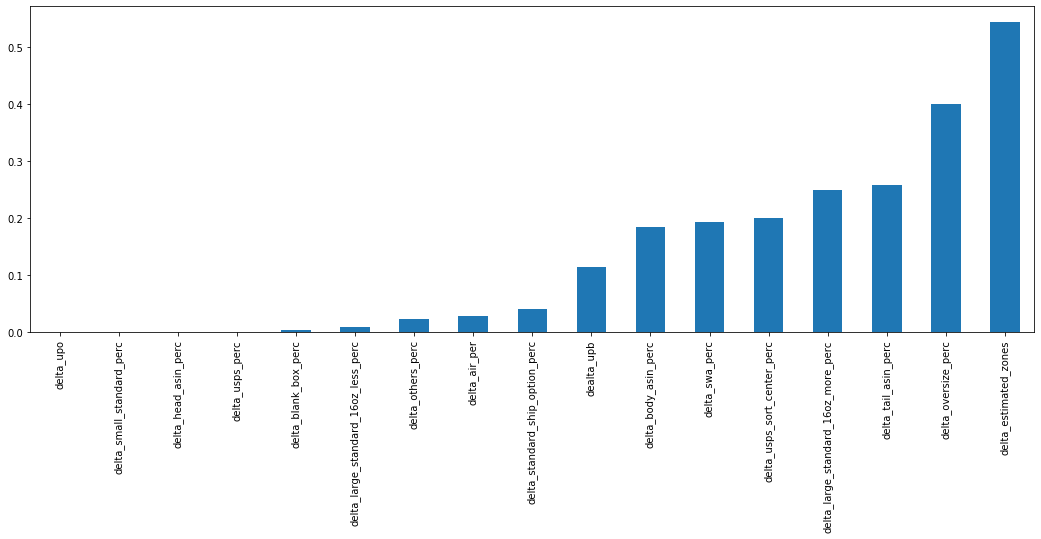

In [32]:
feature_importance = pd.Series(index = x.columns, data = abs(model.coef_))

n_selected_features = (feature_importance!=0).sum()
print('{0:d} features, reduction of {1:2.2f}%'.format(
    n_selected_features,(1-n_selected_features/len(feature_importance))*100))

feature_importance.sort_values().tail(30).plot(kind = 'bar', figsize = (18,6))

In [23]:
feature_importance

delta_upo                              0.000000
dealta_upb                            -0.114757
delta_estimated_zones                  0.544458
delta_air_per                          0.029371
delta_blank_box_perc                  -0.003861
delta_standard_ship_option_perc       -0.040755
delta_head_asin_perc                  -0.000000
delta_body_asin_perc                  -0.184383
delta_tail_asin_perc                   0.258009
delta_usps_sort_center_perc           -0.200055
delta_usps_perc                        0.000000
delta_swa_perc                        -0.193459
delta_others_perc                     -0.022727
delta_small_standard_perc              0.000000
delta_oversize_perc                    0.400034
delta_large_standard_16oz_less_perc    0.008935
delta_large_standard_16oz_more_perc   -0.249426
dtype: float64

In [16]:
# Further verify correlation
x.corr()

,delta_upo,dealta_upb,delta_estimated_zones,delta_air_per,delta_blank_box_perc,delta_standard_ship_option_perc,delta_head_asin_perc,delta_body_asin_perc,delta_tail_asin_perc,delta_usps_sort_center_perc,delta_usps_perc,delta_swa_perc,delta_others_perc,delta_small_standard_perc,delta_oversize_perc,delta_large_standard_16oz_less_perc,delta_large_standard_16oz_more_perc
delta_upo,1.000000,0.665129,-0.159366,-0.143455,-0.189206,-0.024368,0.049239,0.044342,-0.124774,0.239895,0.035432,-0.090520,-0.060921,-0.108115,0.054855,0.100882,0.078082
dealta_upb,0.665129,1.000000,-0.090714,-0.112039,-0.073517,-0.026470,0.060610,0.019732,-0.123341,0.067244,0.164116,0.000692,-0.210312,-0.070668,0.085534,-0.076222,0.114682
delta_estimated_zones,-0.159366,-0.090714,1.000000,0.237793,0.744227,-0.298533,0.006373,-0.090939,0.067695,-0.524298,0.130758,0.102646,-0.184233,0.083025,-0.339883,0.206977,-0.148025
delta_air_per,-0.143455,-0.112039,0.237793,1.000000,-0.122677,0.096794,-0.064469,-0.012429,0.123960,0.134915,0.203214,-0.330824,0.316989,0.089883,-0.386479,0.131407,-0.108574
delta_blank_box_perc,-0.189206,-0.073517,0.744227,-0.122677,1.000000,-0.022536,0.293607,-0.317538,-0.240554,-0.416927,-0.068306,0.142926,-0.355160,0.308311,-0.337104,-0.055826,-0.307052
delta_standard_ship_option_perc,-0.024368,-0.026470,-0.298533,0.096794,-0.022536,1.000000,0.604092,-0.556438,-0.579741,0.319044,-0.177858,-0.164737,0.040790,0.611241,-0.362788,-0.390105,-0.525047
delta_head_asin_perc,0.049239,0.060610,0.006373,-0.064469,0.293607,0.604092,1.000000,-0.932243,-0.949690,0.155657,-0.171746,-0.212625,-0.256662,0.828931,-0.621578,-0.472720,-0.715224
delta_body_asin_perc,0.044342,0.019732,-0.090939,-0.012429,-0.317538,-0.556438,-0.932243,1.000000,0.772023,-0.156657,0.121755,0.252253,0.164676,-0.844642,0.557476,0.467765,0.751201
delta_tail_asin_perc,-0.124774,-0.123341,0.067695,0.123960,-0.240554,-0.579741,-0.949690,0.772023,1.000000,-0.137827,0.196662,0.154999,0.308238,-0.724914,0.609371,0.425396,0.606073
delta_usps_sort_center_perc,0.239895,0.067244,-0.524298,0.134915,-0.416927,0.319044,0.155657,-0.156657,-0.137827,1.000000,-0.051063,-0.703487,0.260976,0.209527,-0.002872,-0.258252,-0.139825


In [30]:
r_sq = model.score(x, y)
print('r_sq:', r_sq)

r_sq: 0.7642351198335146


In [19]:
x1 = x.drop(['delta_upo','delta_tail_asin_perc','delta_usps_perc','delta_small_standard_perc'
             ,'delta_blank_box_perc','delta_air_per','delta_standard_ship_option_perc','delta_others_perc'
            ,'delta_large_standard_16oz_less_perc'], axis=1)

x1 = 

x2 = sm.add_constant(x1)
est = sm.OLS(y, x2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:      delta_sc_per_unit   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     35.63
Date:                Fri, 23 Apr 2021   Prob (F-statistic):           6.74e-24
Time:                        11:13:44   Log-Likelihood:                 103.13
No. Observations:                  93   AIC:                            -188.3
Df Residuals:                      84   BIC:                            -165.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

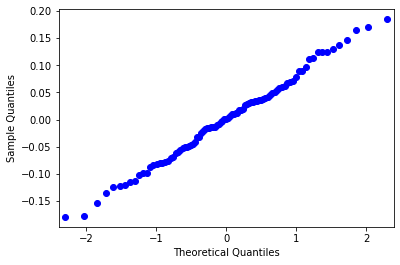

In [17]:
import matplotlib.pyplot as plt
res = est2.resid
fig = sm.qqplot(res)
plt.show()